In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import torch.optim as optim

cuda = torch.cuda.is_available()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.2.1+cu118  Device: cuda


In [2]:
negative_csv = 'CADDY_gestures_all_true_negatives_release_v2.csv'
positive_csv = 'CADDY_gestures_all_true_positives_release_v2.csv'

In [3]:
df = pd.read_csv(positive_csv)
df['stereo left'] = '.' + df['stereo left']
df['stereo right'] = '.' + df['stereo right']

df.head()

,index,scenario,stereo left,stereo right,label name,label id,roi left,roi right,synthetic,iqa_mdm_entropy,iqa_mdm_d,iqa_mdm_dcomp,distortion,param 1,param 2
0,0,biograd-A,./biograd-A/true_positives/raw/biograd-A_00000...,./biograd-A/true_positives/raw/biograd-A_00000...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",0,6.971026,0.957653,0.902,NaN,NaN,NaN
1,1,biograd-A,./biograd-A/true_positives/blurred/dir_00/biog...,./biograd-A/true_positives/blurred/dir_00/biog...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,7,NaN
2,2,biograd-A,./biograd-A/true_positives/blurred/dir_01/biog...,./biograd-A/true_positives/blurred/dir_01/biog...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,11,NaN
3,3,biograd-A,./biograd-A/true_positives/blurred/dir_02/biog...,./biograd-A/true_positives/blurred/dir_02/biog...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,blur,15,NaN
4,4,biograd-A,./biograd-A/true_positives/noisy/dir_00/biogra...,./biograd-A/true_positives/noisy/dir_00/biogra...,num_delimiter,10,"[237,236,54,65]","[155,236,54,65]",1,NaN,NaN,NaN,channel noise,5,NaN


In [4]:
df2 = pd.read_csv(negative_csv)
df2['stereo left'] = '.' + df2['stereo left']
df2['stereo right'] = '.' + df2['stereo right']

df2.head()

,index,scenario,stereo left,stereo right,selected img,label name,label id,roi params,synthetic,distortion type,dist. param 1,dist. param 2
0,0,biograd-A,./biograd-A/true_negatives/raw/biograd-A_00000...,./biograd-A/true_negatives/raw/biograd-A_00000...,NaN,true_neg,-1,NaN,0,NaN,NaN,NaN
1,1,biograd-A,./biograd-A/true_negatives/blurred/dir_00/biog...,./biograd-A/true_negatives/blurred/dir_00/biog...,NaN,true_neg,-1,NaN,1,blur,7,NaN
2,2,biograd-A,./biograd-A/true_negatives/blurred/dir_01/biog...,./biograd-A/true_negatives/blurred/dir_01/biog...,NaN,true_neg,-1,NaN,1,blur,11,NaN
3,3,biograd-A,./biograd-A/true_negatives/blurred/dir_02/biog...,./biograd-A/true_negatives/blurred/dir_02/biog...,NaN,true_neg,-1,NaN,1,blur,15,NaN
4,4,biograd-A,./biograd-A/true_negatives/noisy/dir_00/biogra...,./biograd-A/true_negatives/noisy/dir_00/biogra...,NaN,true_neg,-1,NaN,1,channel noise,5,NaN


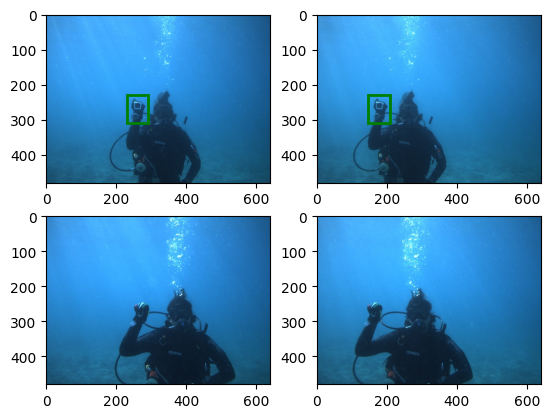

(480, 640, 3)


In [5]:
import matplotlib.patches as patches

fig, ax = plt.subplots(2,2)
for i, side in enumerate(['left','right']):
    test_image = df.iloc[10]['stereo '+side]
    roi_coords = df.iloc[10]['roi '+side][1:-1]
    top_row, top_column, width, height = roi_coords.split(',')
    
    img = cv2.imread(test_image)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    rectangle = patches.Rectangle((int(top_row), int(top_column)), int(width), int(height), edgecolor='g', linewidth=2, fill=False)
        
    ax[0,i].imshow(rgb)
    ax[0,i].add_patch(rectangle)

for i, side in enumerate(['left','right']):
    test_image = df2.iloc[10]['stereo '+side]
    
    img = cv2.imread(test_image)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ax[1,i].imshow(rgb)
    
plt.show()

print(img.shape)

In [6]:
#Seleting raw stereo photos
raw_df = df[df['iqa_mdm_entropy'].notnull()].reset_index(drop=True)
raw_df2 = df2[df2['synthetic']==0].reset_index(drop=True)

#Filling in nan values
raw_df.loc[:,'roi left'] = raw_df['roi left'].fillna(str([-1,-1,0,0]))
raw_df.loc[:,'roi right'] = raw_df['roi right'].fillna(str([-1,-1,0,0]))

In [8]:
from sklearn.model_selection import train_test_split

usable_positive_df, _ = train_test_split(raw_df, test_size = 0.4, stratify=raw_df['label id'],random_state=42)
usable_negative_df, _ = train_test_split(raw_df2, test_size=0.4, random_state = 42)

trainval_df, test_df = train_test_split(usable_positive_df,test_size=0.2, stratify=usable_positive_df['label id'],random_state=42)
train_df, val_df = train_test_split(trainval_df,test_size=0.2, stratify=trainval_df['label id'], random_state=42)

trainval_df2, test_df2 = train_test_split(usable_negative_df,test_size=0.2, random_state=42)
train_df2, val_df2 = train_test_split(trainval_df2,test_size=0.2, random_state=42)

pos_train_df = train_df.reset_index(drop=True)
pos_val_df   = val_df.reset_index(drop=True)
pos_test_df  = test_df.reset_index(drop=True)

neg_train_df = train_df2.reset_index(drop=True)
neg_val_df   = val_df2.reset_index(drop=True)
neg_test_df  = test_df2.reset_index(drop=True)

print('Training mini-dataset:', len(pos_train_df)+len(neg_train_df))
print('Validation mini-dataset:', len(pos_val_df)+len(neg_val_df))
print('Testing mini-dataset:', len(pos_test_df)+len(neg_test_df))

Training mini-dataset: 6307
Validation mini-dataset: 1578
Testing mini-dataset: 1972


In [9]:
class ToTensor(object):

  def __call__(self, sample):
    image, mask = sample['image'], sample['mask']
    mask = mask.transpose((2,0,1))
    image = image.transpose((2,0,1))
    return {'image': torch.from_numpy(image), 'mask': torch.from_numpy(mask)}

In [10]:
class ImageDataset(Dataset):
    def __init__(self, pos_dataframe, neg_dataframe, transform=None):
        self.pos_df = pos_dataframe
        self.neg_df = neg_dataframe
        self.transform = transform
        #Pre-allocating resources (malloc-like behavior)
        self.data = np.zeros((self.pos_df.shape[0]+self.neg_df.shape[0], 480//3, 212,3), dtype=np.uint8)
        self.target = np.zeros((self.pos_df.shape[0]+self.neg_df.shape[0], 480//3, 212,2), dtype=np.uint8)
        self.obtain_images()

    def obtain_images(self):
        file_col = 'stereo left'
        roi_col = 'roi left'
        #Traversing through each row in positive dataset
        for order, row in self.pos_df.iterrows():
            path = row[file_col]
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resizing to ~1/3 of its original size
            self.data[order] = cv2.resize(img, (212, 480//3), interpolation = cv2.INTER_AREA)
            #Cleaning roi string (w/o brackets)
            roi_str = str(row[roi_col]).replace('[', '').replace(']', '')
            for sub_roi in roi_str.split(';'):
                top_row, top_column, width, height = self.get_coordinates(sub_roi)                    
                #Checking if the image has a ROI
                if top_row != -1 and top_column != -1:
                    self.target[order, top_row:top_row+height, top_column:top_column+width,1] = 255
                else:
                    pass
        #Traversing through each row in negative dataset
        for order, row in self.neg_df.iterrows():
            path = row[file_col]
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #Resizing to ~1/3 of its original size
            self.data[order+self.pos_df.shape[0]] = cv2.resize(img, (212, 480//3), interpolation = cv2.INTER_AREA)
            
    def normalize(self, image_arr):
        return (image_arr - image_arr.min()) / (image_arr.max() - image_arr.min())

    def get_coordinates(self, item: str):
        (top_column, top_row, width, height) = item.split(',')
        top_row = int(top_row) //3
        top_col = int(top_column)//3
        width   = int(width)//3
        height  = int(height)//3
        return top_row, top_col, width, height
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.normalize(self.data[index])
        y = self.target[index]/255.
        sample = {'image': x, 'mask': y}
        if self.transform:
          sample = self.transform(sample)
        return sample

In [11]:
transform = transforms.Compose([ToTensor(),transforms.ToDtype(torch.float32, scale=True)])

train_ds = ImageDataset(pos_train_df, neg_train_df, transform=transform)
val_ds   = ImageDataset(pos_val_df, neg_val_df, transform=transform)
test_ds  = ImageDataset(pos_test_df, neg_test_df, transform=transform)

torch.Size([3, 160, 212])
torch.Size([2, 160, 212])


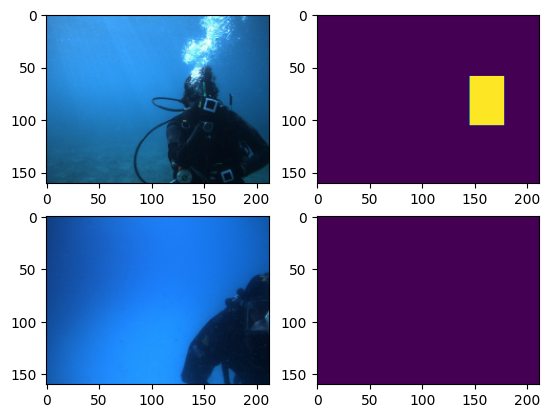

In [12]:
fig, ax = plt.subplots(2,2)

sample = train_ds[0]

print(sample['image'].shape)
print(sample['mask'].shape)

ax[0][0].imshow(sample['image'].numpy().transpose((1, 2, 0)))
ax[0][1].imshow(sample['mask'].numpy().transpose((1, 2, 0))[:,:,1])
sample = train_ds[-1]
ax[1][0].imshow(sample['image'].numpy().transpose((1, 2, 0)))
ax[1][1].imshow(sample['mask'].numpy().transpose((1, 2, 0))[:,:,1])
plt.show()

In [13]:
batch_size = 16
validation_size = 1

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(dataset=val_ds, batch_size=validation_size, shuffle=False)

In [14]:
for sample in train_loader:
    print('X_train:', sample['image'].size(), 'type:', sample['image'].type())
    print('y_train:', sample['mask'].size(), 'type:', sample['mask'].type())
    break

X_train: torch.Size([16, 3, 160, 212]) type: torch.FloatTensor
y_train: torch.Size([16, 2, 160, 212]) type: torch.DoubleTensor


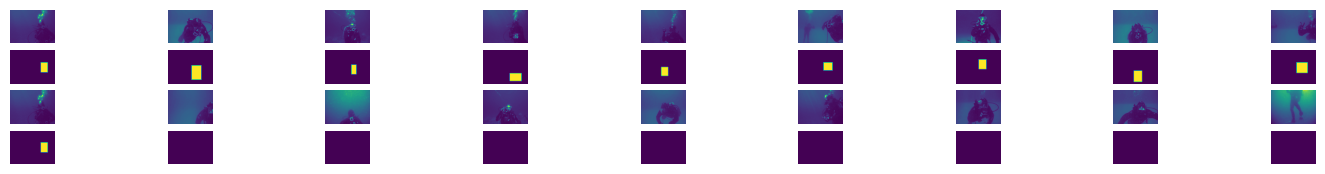

In [15]:
pltsize=2
plt.figure(figsize=(10*pltsize, pltsize))
for i in range(9):
    plt.subplot(4,10,i+1)
    plt.axis('off')
    plt.imshow(train_ds[i]['image'][0])
    plt.subplot(4,10,10+i+1)
    plt.axis('off')
    plt.imshow(train_ds[i]['mask'][1])

    plt.subplot(4,10,20+i+1)
    plt.axis('off')
    plt.imshow(train_ds[-i]['image'][0])
    plt.subplot(4,10,30+i+1)
    plt.axis('off')
    plt.imshow(train_ds[-i]['mask'][1])

    #plt.title('Class: '+str(y_train[i].item()))

In [16]:
#  U - NET
# https://github.com/jaxony/unet-pytorch/blob/master/model.py

def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2)
    else:
        # out_channels is always going to be the same
        # as in_channels
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)


class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))   
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, 
                 merge_mode='concat', up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels, self.out_channels, 
            mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(
                2*self.out_channels, self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597
    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).
    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5, 
                 start_filts=64, up_mode='transpose', 
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the 
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))
    
        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight)
            init.constant_(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []
         
        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)
        
        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [17]:
device = torch.device('cuda')
model = UNet(num_classes = 2, in_channels = 3, depth=3, start_filts = 16, merge_mode='concat').to(device)
summary(model, (3, 160, 212))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 160, 212]             448
            Conv2d-2         [-1, 16, 160, 212]           2,320
         MaxPool2d-3          [-1, 16, 80, 106]               0
          DownConv-4  [[-1, 16, 80, 106], [-1, 16, 160, 212]]               0
            Conv2d-5          [-1, 32, 80, 106]           4,640
            Conv2d-6          [-1, 32, 80, 106]           9,248
         MaxPool2d-7           [-1, 32, 40, 53]               0
          DownConv-8  [[-1, 32, 40, 53], [-1, 32, 80, 106]]               0
            Conv2d-9           [-1, 64, 40, 53]          18,496
           Conv2d-10           [-1, 64, 40, 53]          36,928
         DownConv-11  [[-1, 64, 40, 53], [-1, 64, 40, 53]]               0
  ConvTranspose2d-12          [-1, 32, 80, 106]           8,224
           Conv2d-13          [-1, 32, 80, 106]          18,464
  

C:\Users\jazg2\miniconda3\envs\RL-env\Lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in scalar add
  total_output += np.prod(summary[layer]["output_shape"])


In [18]:
device = torch.device('cuda')
torch.cuda.empty_cache()
train_loss_list = []
val_loss_list = []
iter = 0
#running_loss = 0
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)#0.00005
for epoch in range(100):
    running_loss = 0.0
    for batch in train_loader:
        x = batch['image'].to(device)
        y = batch['mask'].to(device)
        out = model(x)
        optimizer.zero_grad()
        loss = loss_fn(torch.sigmoid(out), y.float()*30+1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iter += 1
    train_loss_list.append(running_loss/len(train_loader))
    with torch.no_grad():
        test_loss = 0.0
        for sample in test_loader:
            x = sample['image'].to(device)
            y = sample['mask'].to(device)
            y_pred = model(x)
            test_loss += loss_fn(torch.sigmoid(y_pred), y.float()*30+1).item()  # sum up batch loss
        val_loss_list.append(test_loss/len(test_loader))        

    print('Iteration %d, train_loss: %.3f, val_loss: %.3f' %(epoch, running_loss / len(train_loader), test_loss/len(test_loader)))

Iteration 0, train_loss: 1.883, val_loss: 1.816
Iteration 1, train_loss: 1.797, val_loss: 1.808
Iteration 2, train_loss: 1.791, val_loss: 1.804
Iteration 3, train_loss: 1.789, val_loss: 1.800
Iteration 4, train_loss: 1.785, val_loss: 1.797
Iteration 5, train_loss: 1.782, val_loss: 1.796
Iteration 6, train_loss: 1.782, val_loss: 1.795
Iteration 7, train_loss: 1.780, val_loss: 1.793
Iteration 8, train_loss: 1.778, val_loss: 1.793
Iteration 9, train_loss: 1.776, val_loss: 1.790
Iteration 10, train_loss: 1.777, val_loss: 1.792
Iteration 11, train_loss: 1.773, val_loss: 1.787
Iteration 12, train_loss: 1.773, val_loss: 1.786
Iteration 13, train_loss: 1.772, val_loss: 1.791
Iteration 14, train_loss: 1.770, val_loss: 1.785
Iteration 15, train_loss: 1.770, val_loss: 1.788
Iteration 16, train_loss: 1.768, val_loss: 1.783
Iteration 17, train_loss: 1.769, val_loss: 1.783
Iteration 18, train_loss: 1.768, val_loss: 1.782
Iteration 19, train_loss: 1.767, val_loss: 1.782
Iteration 20, train_loss: 1.76

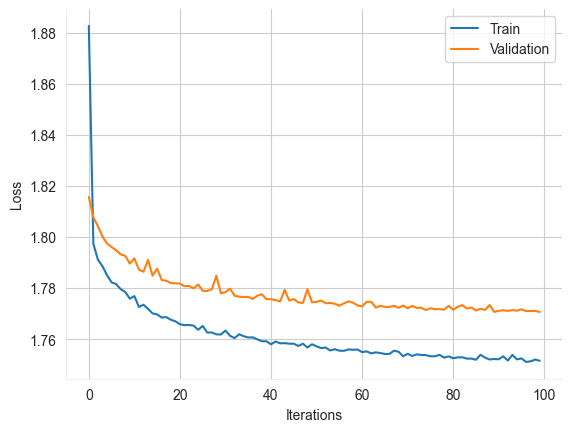

In [20]:
import seaborn as sns
sns.set_style('whitegrid')

plt.figure()
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)

There are some signs of overfitting, should add some augmentation techniques, increase the dataset size and/or decrease the number of trainable parameters.

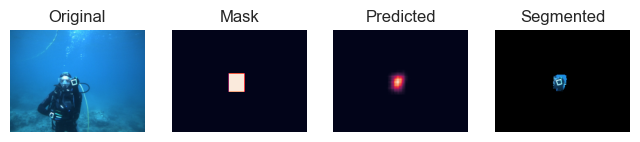

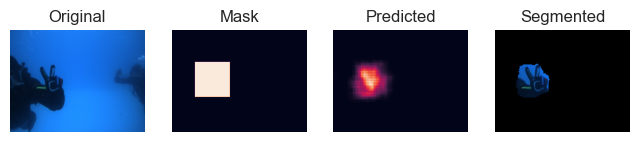

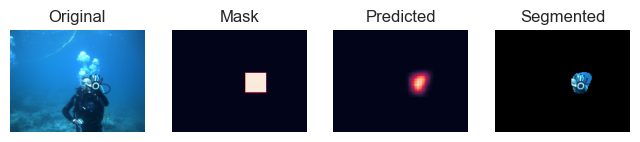

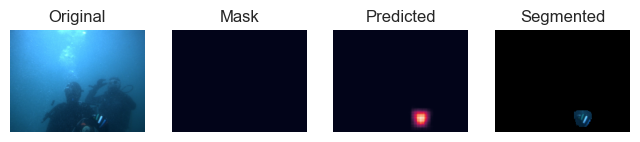

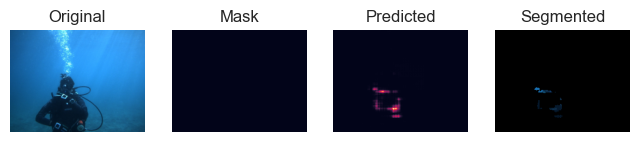

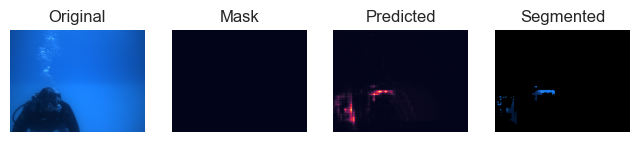

Test loss: 1.7440467972416993


In [21]:
test_loss = 0.0

pos_imgs_to_plot = [50,200,400]
neg_imgs_to_plot = [len(validation_loader)-50, len(validation_loader)-100, len(validation_loader)-150]

with torch.no_grad():
        val_loss = 0.0
        for idx, sample in enumerate(validation_loader):
            x = sample['image'].to(device)
            y = sample['mask'].to(device)
            y_pred = model(x)
            test_loss += loss_fn(torch.sigmoid(y_pred), y.float()*30+1).item()

            if idx in pos_imgs_to_plot or idx in neg_imgs_to_plot:
                og = x.transpose(1,3)[0,:,:,:].cpu().numpy()
                out= y.transpose(1,3)[0,:,:,1].cpu().numpy()
                pred=y_pred.transpose(1,3)[0,:,:,1].cpu().numpy()

                pred/=np.max(pred)
                thresh = 0.2
                mask = np.where(pred>=thresh, 1.0, 0.0).astype(np.uint8)

                res = cv2.bitwise_and((255*og).astype(np.uint8), (255*og).astype(np.uint8), mask=mask)
                #plt.subplot(141)
                fig, ax = plt.subplots(1,4,figsize=(8,4))
                ax[0].axis('off')
                ax[0].imshow(np.rot90(og,-1))
                ax[0].set_title('Original')
                #ax.subplot(142)
                ax[1].axis('off')
                ax[1].imshow(np.rot90(out,-1))
                ax[1].set_title('Mask')
                #.subplot(143)
                ax[2].axis('off')
                ax[2].imshow(np.rot90(pred,-1))
                ax[2].set_title('Predicted')
                #plt.subplot(144)
                ax[3].axis('off')
                ax[3].imshow(np.rot90(res,-1))
                ax[3].set_title('Segmented')
                plt.show()
                
                
print('Test loss:', test_loss/len(validation_loader))